import required libraries for this model

In [1]:
import sqlite3
import numpy as np
import cv2
from PIL import Image
from io import BytesIO
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

check version of tensorflow to be compatible with version on google colab

In [2]:
print(tf.__version__)

2.16.1


make connection to local database for training data. 
No need to host on RDS because once model is trained, no longer need dataset.

In [3]:
conn = sqlite3.connect('C:/Users/Andy/Documents/vscode/Vision_Tradingbot/andy/trading_data.db')

pull from sqlite3 database to create dataframe for the dataset

In [4]:
table_name = 'trading_data'
query = f"SELECT * FROM {table_name}"
df = pd.read_sql_query(query, conn)
df.replace('null', pd.NA, inplace = True)
df.dropna(inplace = True)
df

,id,image_data,tradable,trend,phase,after
0,5,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,up,pullback,continues pull back
1,6,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,down,pullback,continues trend
2,7,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,down,pullback,breaks structure and reverses
3,8,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,down,consolidation,continues trend
4,9,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,down,pullback,continues trend
...,...,...,...,...,...,...
295,300,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,down,pullback,consolidates/no trend
297,302,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,down,consolidation,breaks structure and reverses
298,303,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,up,pullback,continues pull back
299,304,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,down,pullback,continues trend


convert the images from binary back to an image represented as a numpy array

In [5]:
def blob_to_image(blob):
    return np.array(Image.open(BytesIO(blob)))

df['images'] = df['image_data'].apply(blob_to_image)
df

,id,image_data,tradable,trend,phase,after,images
0,5,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,up,pullback,continues pull back,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,6,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,down,pullback,continues trend,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2,7,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,down,pullback,breaks structure and reverses,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
3,8,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,down,consolidation,continues trend,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
4,9,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,down,pullback,continues trend,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
...,...,...,...,...,...,...,...
295,300,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,down,pullback,consolidates/no trend,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
297,302,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,down,consolidation,breaks structure and reverses,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
298,303,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,up,pullback,continues pull back,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
299,304,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,down,pullback,continues trend,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


create two numpy arrays, one containing the images, the other containing the labels

In [6]:
images = np.array(df['images'])
labels = df[['trend', 'phase', 'after']].values

print out and show the data we are working with.

In [7]:
print(images[0])
print(labels[0])

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[224 227 235]
  [224 227 235]
  [224 227 235]
  ...
  [175 178 187]
  [175 178 187]
  [175 178 187]]

 [[224 227 235]
  [224 227 235]
  [224 227 235]
  ...
  [184 187 196]
  [184 187 196]
  [184 187 196]]

 ...

 [[224 227 235]
  [224 227 235]
  [224 227 235]
  ...
  [233 233 233]
  [233 233 233]
  [233 233 233]]

 [[224 227 235]
  [224 227 235]
  [224 227 235]
  ...
  [233 233 233]
  [233 233 233]
  [233 233 233]]

 [[224 227 235]
  [224 227 235]
  [224 227 235]
  ...
  [233 233 233]
  [233 233 233]
  [233 233 233]]]
['up' 'pullback' 'continues pull back']


verify that the numpy array full of images in numpy array form are valid and that they represent a single image

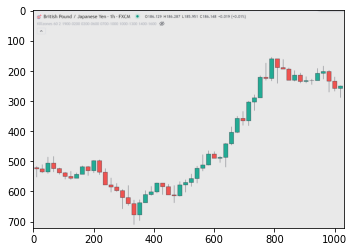

In [8]:
sample_image = images[0]
plt.imshow(sample_image)

confirm that the list of images are infact numpy arrays each representing an image

In [9]:
# Assuming 'images' is your NumPy array of images
for i, img in enumerate(images):
    print(f"Element {i} - Type: {type(img)}, Shape: {img.shape}")


Element 0 - Type: <class 'numpy.ndarray'>, Shape: (721, 1030, 3)
Element 1 - Type: <class 'numpy.ndarray'>, Shape: (721, 1030, 3)
Element 2 - Type: <class 'numpy.ndarray'>, Shape: (721, 1030, 3)
Element 3 - Type: <class 'numpy.ndarray'>, Shape: (721, 1030, 3)
Element 4 - Type: <class 'numpy.ndarray'>, Shape: (721, 1030, 3)
Element 5 - Type: <class 'numpy.ndarray'>, Shape: (721, 1030, 3)
Element 6 - Type: <class 'numpy.ndarray'>, Shape: (721, 1030, 3)
Element 7 - Type: <class 'numpy.ndarray'>, Shape: (721, 1030, 3)
Element 8 - Type: <class 'numpy.ndarray'>, Shape: (721, 1030, 3)
Element 9 - Type: <class 'numpy.ndarray'>, Shape: (721, 1030, 3)
Element 10 - Type: <class 'numpy.ndarray'>, Shape: (721, 1030, 3)
Element 11 - Type: <class 'numpy.ndarray'>, Shape: (721, 1030, 3)
Element 12 - Type: <class 'numpy.ndarray'>, Shape: (721, 1030, 3)
Element 13 - Type: <class 'numpy.ndarray'>, Shape: (721, 1030, 3)
Element 14 - Type: <class 'numpy.ndarray'>, Shape: (721, 1030, 3)
Element 15 - Type: <

normalize the images by dividing by 255 and turning the values into a np.float32

In [10]:
images_float32 = [img.astype(np.float32) / 255.0 for img in images]
images_float32 = np.array(images_float32)

initialize three label encoder objects for each category.
Each colum of the labels (trend, phase, after) are turned into numeral format
uses list slicing to select rows from each column.

In [11]:
label_encoder_trend = LabelEncoder()
label_encoder_phase = LabelEncoder()
label_encoder_after = LabelEncoder()

labels[:, 0] = label_encoder_trend.fit_transform(labels[:, 0])
labels[:, 1] = label_encoder_phase.fit_transform(labels[:, 1])
labels[:, 2] = label_encoder_after.fit_transform(labels[:, 2])

use sklearn train test split to split up the training and testing data 80/20

In [12]:
X_train, X_test, y_train, y_test = train_test_split(images_float32, labels, test_size = 0.2, random_state = 42)

In [ ]:
'''
y_train_one_hot = []
for category_labels in y_train.T:
    category_onehot = to_categorical(category_labels)
    y_train_one_hot.append(category_onehot)
y_test_one_hot = []
for category_labels in y_test.T:
    category_onehot = to_categorical(category_labels)
    y_test_one_hot.append(category_onehot)

y_train_one_hot = np.concatenate(y_train_one_hot, axis=1)
y_test_one_hot = np.concatenate(y_test_one_hot, axis=1)
'''

In [14]:
y_train_one_hot = [to_categorical(label, num_classes=num_classes) for label, num_classes in zip(y_train.T, [3, 3, 4])]
y_test_one_hot = [to_categorical(label, num_classes=num_classes) for label, num_classes in zip(y_test.T, [3, 3, 4])]

In [20]:
print(y_test_one_hot)

[array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 

basic CNN model:
input layer specifies shape of the input data
convolutional layer specifies 32 filters and a kernal size of (3,3) using ReLU activation function.
flatten layer flattens the output of previous convolutional layer into a 1D array.
dense layer is the fully connected layer with 3 units for the 3 output of classes.

In [21]:
model = tf.keras.Sequential()
model.add(Input(shape = (721, 1030, 3)))
model.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(3, activation = 'softmax'))

compile the model with adam optimizer and loss function of categorical crossentropy (used for multi class classification)

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

summary of model showing all parameters.
paramters are the amount of weights/biases that can be adjusted by the neural network to affect the overall outcome.

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 719, 1028, 32)  │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 23652224)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │    70,956,675 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,957,571 (270.68 MB)

 Trainable params: 70,957,571 (270.68 MB)

 Non-trainable params: 0 (0.00 B)

train the model with the dataset specifying hyper parameters.
epoch: number of times the dataset is put through the model
batch: number of training data that goes into the model at one learning session at a time.

In [24]:
model.fit(X_train, y_train_one_hot, epochs = 5, batch_size = 32, validation_data = (X_test, y_test_one_hot))

Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.3754 - loss: 2133.8582 - val_accuracy: 0.4464 - val_loss: 1365.1188
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.4633 - loss: 785.2386 - val_accuracy: 0.4464 - val_loss: 765.8047
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.4195 - loss: 440.3763 - val_accuracy: 0.1071 - val_loss: 408.6841
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.3561 - loss: 257.1189 - val_accuracy: 0.4464 - val_loss: 213.9089
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.5637 - loss: 103.9814 - val_accuracy: 0.7143 - val_loss: 24.6161


get results of the model from the built in evaulation tool
Takes accuracy as the metric.
accuracy = # of correctly predicted samples / total number of samples

In [25]:
evaluation_results = model.evaluate(X_test, y_test_one_hot)
print("Evaluation results:", evaluation_results)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step - accuracy: 0.6949 - loss: 25.0044
Evaluation results: [24.61612892150879, 0.7142857313156128]


obtain predictions for the x_test data to compare with the actual testing y data as ground truths.

In [26]:
# Predict classes
y_pred = model.predict(X_test)
y_true = y_test

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 628ms/step


In [41]:
print(y_pred[0])
print(y_true[0])

[1.0000000e+00 0.0000000e+00 1.2987766e-12]
[1 0 3]


In [28]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

In [29]:
"""y_pred_trend = label_encoder_trend.inverse_transform(y_pred_classes)
y_true_trend = label_encoder_trend.inverse_transform(y_true_classes)

y_pred_phase = label_encoder_phase.inverse_transform(y_pred_classes)
y_true_phase = label_encoder_phase.inverse_transform(y_true_classes)

y_pred_after = label_encoder_after.inverse_transform(y_pred_classes)
y_true_after = label_encoder_after.inverse_transform(y_true_classes)
"""

In [36]:
decoded_classes_trend = label_encoder_trend.inverse_transform(range(len(label_encoder_trend.classes_)))
decoded_classes_phase = label_encoder_phase.inverse_transform(range(len(label_encoder_phase.classes_)))
decoded_classes_after = label_encoder_after.inverse_transform(range(len(label_encoder_after.classes_)))

In [40]:
print("Classification Report (Trend):")
#print(classification_report(y_true_trend, y_pred_trend))
print(classification_report(y_true_classes, y_pred_classes, target_names=decoded_classes_trend))
# Classification report for "phase" category
#print("Classification Report (Phase):")
#print(classification_report(y_true_phase, y_pred_phase))

# Classification report for "after" category
#print("Classification Report (After):")
#print(classification_report(y_true_after, y_pred_after))

Classification Report (Trend):
              precision    recall  f1-score   support

        down       0.14      0.23      0.17        13
    no trend       0.00      0.00      0.00        10
          up       0.53      0.55      0.54        33

    accuracy                           0.38        56
   macro avg       0.22      0.26      0.24        56
weighted avg       0.34      0.38      0.36        56



c:\Users\Andy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Andy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Andy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [31]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 3  0 10]
 [ 4  0  6]
 [15  0 18]]


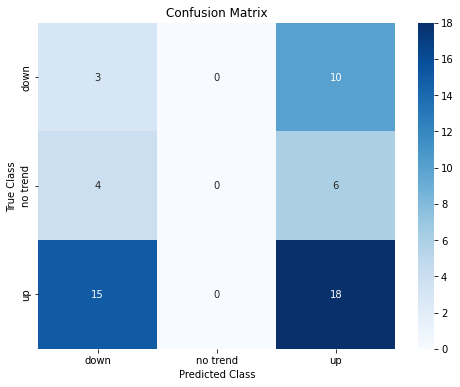

In [37]:
# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=decoded_classes_trend, yticklabels=decoded_classes_trend)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#model.save('tradebot_v1.keras')